<a href="https://colab.research.google.com/github/pandaharya/classification-music/blob/main/CNN_Akurasi_72.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Import Library**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opendatasets
# Usual Library
import pandas as pd
import numpy as np
import sklearn
import os
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Audio Library
import librosa

# Classification Library
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **3. Dataset**

### **3.1 Dataset Audio untuk Klasifikasi**

In [ ]:
# Read Dataset
audio_data = '/content/drive/MyDrive/Data/genres_original'
print('Genre :')
print(list(os.listdir(audio_data)))
print('\n')

metadata = pd.read_csv('/content/drive/MyDrive/Data/features_30_sec.csv')
metadata.head()

Genre :
['pop', 'jazz', 'rock', 'metal', 'country', 'blues', 'disco', 'reggae', 'hiphop', 'classical']




,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


## **4. Ekstraksi Fitur MFCC (Mel Frequency Cepstral Coefficients)**

In [ ]:
def features(data):
  audio, sample_rate = librosa.load(data_name, res_type="kaiser_fast")
  mfccs_features = librosa.feature.mfcc(y = audio, sr=22050 , n_mfcc = 40) #36565
  mfccs_var = np.var(mfccs_features.T, axis=0)
  mfccs_mean = np.mean(mfccs_features.T, axis=0)
  mfcc = mfccs_var+mfccs_mean
  
  return mfcc

In [ ]:
# Ekstraksi fitur MFCC untuk seluruh data audio

extracted_features=[]
for index_num, row in tqdm(metadata.iterrows()):
    try:
        final_class_labels = row["label"]
        data_name = os.path.join(os.path.abspath(audio_data), final_class_labels+'/', str(row["filename"]))    
        data = features(data_name)
        extracted_features.append([data, final_class_labels])
    except Exception as e:
        print(f"Error: {e}")
        continue

555it [03:28,  1.90it/s]

Error: [Errno 2] No such file or directory: '/content/drive/MyDrive/Data/genres_original/jazz/jazz.00054.wav'


1000it [06:05,  2.73it/s]


In [ ]:
# Print hasil ekstraksi fitur
df = pd.DataFrame(extracted_features, columns=['feature','class'])
df.head()

,feature,class
0,"[2450.637, 417.4856, 216.4063, 193.4733, 161.5...",blues
1,"[7557.0537, 684.25116, 581.76605, 300.38376, 2...",blues
2,"[3228.3223, 649.21136, 382.6873, 175.77466, 14...",blues
3,"[5307.9727, 606.5962, 262.82385, 185.12637, 26...",blues
4,"[5034.9546, 980.0044, 298.20514, 215.60417, 30...",blues


In [ ]:
# Hitung jumlah data per kelas
df['class'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          99
Name: class, dtype: int64

In [ ]:
# Independent Dataset
# Ubah data dari list menjadi array

X = np.array(df['feature'].tolist())
y = np.array(df['class'].tolist())

In [ ]:
print('X shape\t:', X.shape)
print('y shape\t:', y.shape)

X shape	: (999, 40)
y shape	: (999,)


## **5. Klasifikasi Genre**

### **5.1 Data Preparation**

#### **1. Encoding Label Genre**

In [ ]:
# Melakukan pengkodean label dengan LabelEncoder()
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
print('y shape after encode label :', y.shape)

y shape after encode label : (999, 10)


#### **2. Splitting Data Train dan Test**

In [ ]:
# Split train dan test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=3)

In [ ]:
print(f"X_train\t{X_train.shape}")
print(f"X_test\t{X_test.shape}")
print(f"y_train\t{y_train.shape}")
print(f"y_test\t{y_test.shape}")

X_train	(849, 40)
X_test	(150, 40)
y_train	(849, 10)
y_test	(150, 10)


### **5.2 Modeling Using Deep Learning**

In [ ]:
# Model Build Deep Learning
model=Sequential()
model.add(Dense(1024, input_shape=(40,), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))

# Final Layer
model.add(Dense(10, activation='softmax'))  

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 1024)              41984     
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)              

In [ ]:
# Compile Model
model.compile(optimizer = "adam",
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [ ]:
# Fit Model
history = model.fit(X_train, y_train,
                 validation_data = (X_test, y_test),
                 epochs = 500,
                 batch_size = 32)

Epoch 1/500
27/27 [==============================] - 0s 7ms/step - loss: 1.0655 - accuracy: 0.7703 - val_loss: 0.4071 - val_accuracy: 0.8933
Epoch 2/500
27/27 [==============================] - 0s 5ms/step - loss: 0.9606 - accuracy: 0.7256 - val_loss: 0.5318 - val_accuracy: 0.8667
Epoch 3/500
27/27 [==============================] - 0s 5ms/step - loss: 1.1037 - accuracy: 0.7102 - val_loss: 0.6343 - val_accuracy: 0.8200
Epoch 4/500
27/27 [==============================] - 0s 5ms/step - loss: 0.9069 - accuracy: 0.7256 - val_loss: 0.4728 - val_accuracy: 0.8733
Epoch 5/500
27/27 [==============================] - 0s 5ms/step - loss: 0.8109 - accuracy: 0.7774 - val_loss: 0.4434 - val_accuracy: 0.8867
Epoch 6/500
27/27 [==============================] - 0s 5ms/step - loss: 0.8351 - accuracy: 0.7562 - val_loss: 0.3871 - val_accuracy: 0.9067
Epoch 7/500
27/27 [==============================] - 0s 6ms/step - loss: 0.9160 - accuracy: 0.7444 - val_loss: 0.5390 - val_accuracy: 0.8400
Epoch 8/500
2

Max. Validation Accuracy 0.9133333563804626


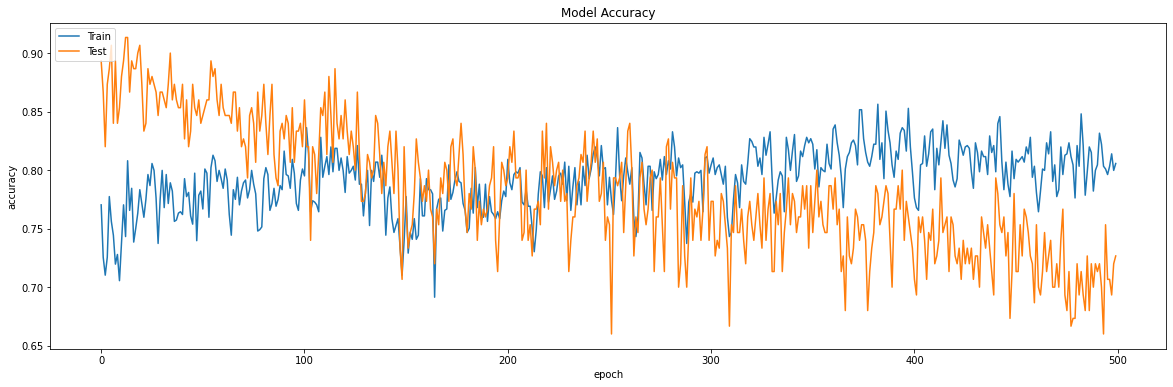

In [ ]:
print("Max. Validation Accuracy", max(history.history["val_accuracy"]))

# Plot Akurasi
plt.figure(figsize=(20,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('plot_akurasi.png')
plt.show()

### **5.3 Model Evaluation**

In [ ]:
# Model evaluasi
test_loss, test_acc  = model.evaluate(X_test, y_test, batch_size=128)
print("Loss Test\t:", test_loss)
print("Accuracy Test\t:", test_acc*100)

2/2 [==============================] - 0s 8ms/step - loss: 0.8578 - accuracy: 0.7267
Loss Test	: 0.857795000076294
Accuracy Test	: 72.66666889190674


### **5.4 Testing Model**

In [ ]:
# Model Predict
predictions = np.argmax(model.predict(X_test), axis=-1)
predictions

5/5 [==============================] - 0s 2ms/step


array([6, 5, 9, 1, 4, 4, 6, 7, 4, 4, 5, 3, 8, 5, 9, 4, 3, 8, 2, 9, 2, 1,
       6, 6, 9, 6, 0, 9, 8, 1, 5, 6, 8, 6, 8, 2, 6, 6, 7, 6, 7, 9, 6, 7,
       2, 9, 5, 1, 9, 6, 3, 8, 7, 3, 4, 8, 1, 0, 5, 2, 0, 1, 0, 0, 9, 5,
       8, 3, 3, 1, 9, 5, 0, 9, 6, 3, 1, 0, 1, 7, 3, 2, 0, 2, 9, 4, 8, 5,
       6, 9, 6, 4, 4, 8, 8, 1, 9, 0, 8, 8, 7, 5, 9, 9, 6, 7, 4, 0, 0, 8,
       2, 7, 7, 7, 1, 7, 9, 9, 4, 6, 6, 2, 6, 5, 3, 6, 3, 0, 2, 1, 1, 7,
       5, 1, 4, 1, 3, 5, 5, 1, 5, 8, 3, 7, 1, 9, 0, 3, 8, 8])

In [ ]:
# Input path audio yang akan di test
filename = "/content/drive/MyDrive/Data/genres_original/country/country.00001.wav"

# Librosa load
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 

# MFCC Fitur Inputan Audio
mfccs_features = librosa.feature.mfcc(y = audio, sr = 22050, n_mfcc = 40)
mfccs_mean = np.mean(mfccs_features.T, axis=0)
mfccs_var = np.var(mfccs_features.T, axis=0)
mfccs_scaled_features = mfccs_mean+mfccs_var
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print('\n', mfccs_scaled_features.shape)

predicted = model.predict(mfccs_scaled_features)
predicted_label = np.argmax(predicted, axis=1)
print("Label Genre\t:", predicted_label)

if predicted_label == [[0]]:
  genre_detected = 'Blues'
elif predicted_label == [[1]]:
  genre_detected = 'Classical'
elif predicted_label == [[2]]:
  genre_detected = 'Country'
elif predicted_label == [[3]]:
  genre_detected = 'Disco'
elif predicted_label == [[4]]:
  genre_detected = 'Hip-hop'
elif predicted_label == [[5]]:
  genre_detected = 'Jazz'
elif predicted_label == [[6]]:
  genre_detected = 'Metal'
elif predicted_label == [[7]]:
  genre_detected = 'Pop'
elif predicted_label == [[8]]:
  genre_detected = 'Reggae'
else:
  genre_detected = 'Rock'

print("Prediksi Genre\t:", genre_detected)

[[354.71594  155.82841  146.78532   88.84415   83.565445 115.91725
   55.020283  63.10066   63.775017  63.20701   48.61479   44.617886
   31.75398   46.547268  48.448494  40.15094   43.300377  51.57726
   42.652157  49.03656   50.066658  52.91017   48.846436  43.98967
   36.609585  40.51784   39.197353  31.41517   38.653282  56.26212
   37.84273   64.751686  61.25022   27.765083  22.812778  39.066093
   50.23103   48.944023  42.388012  66.551125]]

 (1, 40)
1/1 [==============================] - 0s 33ms/step
Label Genre	: [2]
Prediksi Genre	: Country


In [ ]:
import numpy

In [ ]:
actual = numpy.random.binomial(1, 0.9, size = 1000)
predicted = numpy.random.binomial(1, 0.9, size = 1000)

In [ ]:
from sklearn import metrics

In [ ]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

In [ ]:
import matplotlib.pyplot as plt

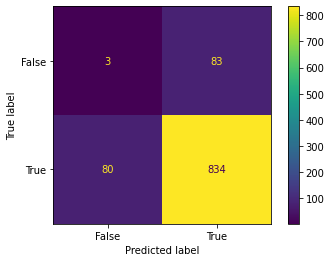

In [ ]:
cm_display.plot()
plt.show()

## **6. Save Model**

In [ ]:
# Save Model
model.save('model.h5')